### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
import torch.functional as F
import torch.nn as nn
from nltk.tokenize import TweetTokenizer
from scipy.stats import beta, shapiro
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

%matplotlib inline

SEED = 42

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Reading data

In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.drop(["LocationRaw", "SalaryRaw", "SourceName", "Id"], axis=1, inplace=True)
data.shape

(244768, 8)

In [4]:
data.head()

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,27500
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000


### Missing values 

In [5]:
data.isna().sum()

Title                      1
FullDescription            0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryNormalized           0
dtype: int64

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = [
    "Category",
    "Company",
    "LocationNormalized",
    "ContractType",
    "ContractTime",
]
target_column = "SalaryNormalized"

For now, let's just fill all the `NA` values with `NaN` 

In [7]:
data = data.fillna("NaN")

## Splitting data

In [8]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=SEED)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

data_train.shape, data_val.shape

((195814, 8), (48954, 8))

## Looking at data

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195814 entries, 0 to 195813
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               195814 non-null  object
 1   FullDescription     195814 non-null  object
 2   LocationNormalized  195814 non-null  object
 3   ContractType        195814 non-null  object
 4   ContractTime        195814 non-null  object
 5   Company             195814 non-null  object
 6   Category            195814 non-null  object
 7   SalaryNormalized    195814 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 12.0+ MB


#### Target

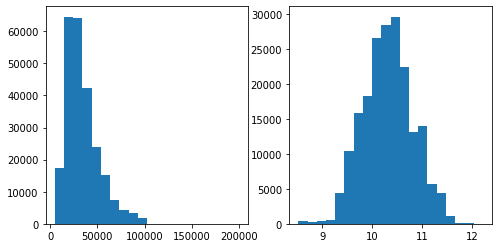

In [10]:
log1pSalary = np.log1p(data_train["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(log1pSalary, bins=20);

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc.

In [11]:
shapiro(log1pSalary)

C:\Users\ryblo\Documents\projects\yandex_nlp_course\venv\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9969059824943542, pvalue=2.802596928649634e-45)

#### Categorical columns

In [12]:
for cat_column in categorical_columns:
    print(
        f"'{cat_column}' column contains {data_train[cat_column].nunique()} unique values"
    )

'Category' column contains 29 unique values
'Company' column contains 18857 unique values
'LocationNormalized' column contains 2543 unique values
'ContractType' column contains 3 unique values
'ContractTime' column contains 3 unique values


##### Category column

In [13]:
data_train["Category"].value_counts()

IT Jobs                             30847
Engineering Jobs                    20159
Accounting & Finance Jobs           17434
Healthcare & Nursing Jobs           16916
Sales Jobs                          13849
Other/General Jobs                  13567
Teaching Jobs                       10137
Hospitality & Catering Jobs          9066
Trade & Construction Jobs            7088
PR, Advertising & Marketing Jobs     7070
HR & Recruitment Jobs                6190
Admin Jobs                           6112
Retail Jobs                          5201
Customer Services Jobs               4794
Legal Jobs                           3145
Manufacturing Jobs                   3027
Logistics & Warehouse Jobs           2912
Social work Jobs                     2743
Consultancy Jobs                     2591
Travel Jobs                          2508
Scientific & QA Jobs                 2010
Charity & Voluntary Jobs             1867
Energy, Oil & Gas Jobs               1821
Creative & Design Jobs            

##### Company column

In [14]:
data_train["Company"].value_counts()

NaN                                                      25884
UKStaffsearch                                             4015
CVbrowser                                                 2387
London4Jobs                                               1859
Hays                                                      1424
                                                         ...  
Oxford University Hospitals NHS Trust                        1
Aspirations Care                                             1
MANPOWER UK LTD                                              1
Zolv.com Ltd                                                 1
The Facial Surgery Research Foundation   Saving Faces        1
Name: Company, Length: 18857, dtype: int64

##### LocationNormalized column

In [15]:
data_train["LocationNormalized"].value_counts()

UK                   32767
London               24483
South East London     9411
The City              5337
Manchester            2859
                     ...  
Kilbarchan               1
Brompton                 1
Kennoway                 1
Kirkby Stephen           1
Grimethorpe              1
Name: LocationNormalized, Length: 2543, dtype: int64

##### ContractType column

In [16]:
data_train["ContractType"].value_counts()

NaN          143245
full_time     46208
part_time      6361
Name: ContractType, dtype: int64

##### ContractTime column

In [17]:
data_train["ContractTime"].value_counts()

permanent    121042
NaN           51332
contract      23440
Name: ContractTime, dtype: int64

## Preparing

### Tokenizer

In [18]:
tokenizer = TweetTokenizer()
# tokenizer = nltk.tokenize.WordPunctTokenizer()

# assert tokenizer.tokenize("I've been doing this for a few years!") == [
#     "I've",
#     "been",
#     "doing",
#     "this",
#     "for",
#     "a",
#     "few",
#     "years",
#     "!",
# ]

## Preprocessor Class

In [19]:
class PreprocessDataset:
    TEXT_COLS = ["Title", "FullDescription"]
    CAT_COLS = [
        "Category",
        "Company",
        "LocationNormalized",
        "ContractType",
        "ContractTime",
    ]
    TARGET_COL = "SalaryNormalized"
    NEW_TARGET_COL = "Log1pSalary"
    UNK, PAD = "UNK", "PAD"
    SEED = 42

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer,
        min_count=10,
        max_len_title=None,
        max_len_description=None,
    ):
        self.tokenizer = tokenizer
        self.data = data

        self.data_train, self.data_val = self._split_data()

        self.data_train = self.preprocess_data(self.data_train, train=True)
        self.data_val = self.preprocess_data(self.data_val)

        self.categorical_vectorizer = self._preprocess_categorical()
        self.vocab = self._build_vocab(min_count)
        self.token_to_id = self._build_token_to_id_dict()
        self.UNK_IX, self.PAD_IX = map(self.token_to_id.get, [self.UNK, self.PAD])
        self.max_len_description = max_len_description
        self.max_len_title = max_len_title

    def preprocess_data(self, data, train=False):
        print(f"Preprocessing {'Train' if train else 'Val'} data")
        data = self._preprocess_texts(data)
        data = self._preprocess_target(data)

        return data

    def _split_data(self, test_size=0.2):
        print("Splitting data to train and val sets")
        data_train, data_val = train_test_split(
            self.data, test_size=test_size, random_state=self.SEED
        )
        data_train.reset_index(drop=True, inplace=True)
        data_val.reset_index(drop=True, inplace=True)

        return data_train, data_val

    def _preprocess_texts(self, data: pd.DataFrame) -> pd.DataFrame:
        for text_col in self.TEXT_COLS:
            tqdm.pandas(desc=f"Tokenizing {text_col}")
            tokenized_texts = data[text_col].progress_apply(self._tokenize)
            data[text_col] = tokenized_texts.values

        return data

    def _preprocess_target(self, data: pd.DataFrame) -> pd.DataFrame:
        print("Preprocessing Target column")
        data[self.NEW_TARGET_COL] = np.log1p(data[self.TARGET_COL]).astype("float32")

        return data

    def _preprocess_categorical(self, most_common=1000):
        print("Preprocessing Categorical columns")

        tqdm.pandas(desc=f"Preprocessing Company column")
        # we only consider top-1k most frequent companies to minimize memory usage
        top_companies, top_counts = zip(
            *Counter(self.data_train["Company"]).most_common(most_common)
        )
        recognized_companies = set(top_companies)
        self.data_train["Company"] = self.data_train["Company"].progress_apply(
            lambda comp: comp if comp in recognized_companies else "Other"
        )

        tqdm.pandas(desc=f"Vectorizing categorical columns")
        categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
        categorical_vectorizer.fit(
            self.data_train[self.CAT_COLS].progress_apply(dict, axis=1)
        )

        return categorical_vectorizer

    def _build_vocab(self, min_count):
        token_counts = Counter()

        # Count how many times does each token occur in both "Title" and "FullDescription" in total
        for str_ in tqdm(
            self.data_train[text_columns].values.flatten(), desc="Building vocab"
        ):
            token_counts.update(str(str_).split())

        print("Total unique tokens :", len(token_counts))
        print("\n".join(map(str, token_counts.most_common(n=5))))
        print("...")
        print("\n".join(map(str, token_counts.most_common()[-3:])))

        # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
        tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

        # Add a special tokens for unknown and empty words
        tokens = [self.UNK, self.PAD] + tokens

        print("Vocabulary size:", len(tokens))
        assert type(tokens) == list
        assert len(tokens) in range(30000, 35000)
        assert "me" in tokens
        assert self.UNK in tokens

        return tokens

    def _build_token_to_id_dict(self):
        token_to_id = {token: i for i, token in enumerate(self.vocab)}

        assert isinstance(token_to_id, dict)
        assert len(token_to_id) == len(self.vocab)
        for token in self.vocab:
            assert self.vocab[token_to_id[token]] == token

        return token_to_id

    def _tokenize(self, text):
        return " ".join(self.tokenizer.tokenize(str(text).lower()))

    def _as_matrix(self, sequences, max_len=None):
        """Convert a list of tokens into a matrix with padding"""

        if isinstance(sequences[0], str):
            sequences = list(map(str.split, sequences))

        max_len = min(max(map(len, sequences)), max_len or float("inf"))

        matrix = np.full((len(sequences), max_len), np.int32(self.PAD_IX))

        for i, seq in enumerate(sequences):
            row_ix = [self.token_to_id.get(word, self.UNK_IX) for word in seq[:max_len]]
            matrix[i, : len(row_ix)] = row_ix

        return matrix

    def _encode_categorical(self, data):
        pass

In [20]:
preprocessor = PreprocessDataset(
    data, tokenizer, max_len_title=10, max_len_description=100
)

Splitting data to train and val sets
Preprocessing Train data


Tokenizing Title:   0%|          | 0/195814 [00:00<?, ?it/s]

Tokenizing FullDescription:   0%|          | 0/195814 [00:00<?, ?it/s]

Preprocessing Target column
Preprocessing Val data


Tokenizing Title:   0%|          | 0/48954 [00:00<?, ?it/s]

Tokenizing FullDescription:   0%|          | 0/48954 [00:00<?, ?it/s]

Preprocessing Target column
Preprocessing Categorical columns


Preprocessing Company column:   0%|          | 0/195814 [00:00<?, ?it/s]

Vectorizing categorical columns:   0%|          | 0/195814 [00:00<?, ?it/s]

Building vocab:   0%|          | 0/391628 [00:00<?, ?it/s]

Total unique tokens : 201108
('and', 2123081)
(',', 1871868)
('.', 1758719)
('*', 1674219)
('the', 1659371)
...
('pate', 1)
('nurseportadown', 1)
('www.salestarget.co.uk/jobseeking/salesexecutivesx2northwestlondonesp***_job***', 1)
Vocabulary size: 31171


## Dataset & Dataloaders & Transforms

We will pass training data with parameter `train=True` with which we will fit our vectorizers and so on and test data with `train=False` with which we will transform our test dataset  
Create one class for dataset preprocessing and another class for using preprocessed dataset for dataloaders

### Transforms

**Add target transform method**

In [21]:
class ApplyWordDropout:
    def __init__(self, replace_with, pad_ix, word_dropout=0.0):
        self.keep_prop = 1.0 - word_dropout
        self.replace_with = replace_with
        self.pad_ix = pad_ix

    def apply_word_dropout(self, matrix):
        dropout_mask = np.random.choice(
            2, np.shape(matrix), p=[self.keep_prop, 1 - self.keep_prop]
        )
        dropout_mask &= matrix != self.pad_ix

        return np.choose(
            dropout_mask, [matrix, np.full_like(matrix, self.replace_with)]
        )

    def __call__(self, sample):
        return self.apply_word_dropout(sample)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, device=DEVICE):
        sample_tensors = dict()
        for key, arr in sample.items():
            if key in ["FullDescription", "Title"]:
                sample_tensors[key] = torch.tensor(arr, dtype=torch.long, device=device)
            else:
                sample_tensors[key] = torch.tensor(arr, device=device)
        return sample_tensors

### Dataset

In [22]:
class VacancyDataset:
    def __init__(self, preprocessor, train=True, transform=None, word_dropout=0):
        self.preprocessor = preprocessor

        self.data = self.preprocessor.data_train if train else preprocessor.data_val

        self.transform = transform
        self.word_dropout = ApplyWordDropout(
            replace_with=self.preprocessor.UNK_IX,
            pad_ix=self.preprocessor.PAD_IX,
            word_dropout=word_dropout,
        )

        self.title = self.preprocessor._as_matrix(
            self.data["Title"].values, self.preprocessor.max_len_title
        )
        self.description = self.preprocessor._as_matrix(
            self.data["FullDescription"].values,
            self.preprocessor.max_len_description,
        )

        if word_dropout != 0:
            self.description = self.word_dropout(self.description)

        self.categorical = self.preprocessor.categorical_vectorizer.transform(
            self.data[self.preprocessor.CAT_COLS].apply(dict, axis=1)
        )

        self.target = self.data[self.preprocessor.NEW_TARGET_COL]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {}
        sample["title_text"] = self.title[idx]
        sample["description_text"] = self.description[idx]
        sample["categorical"] = self.categorical[idx]
        sample["target"] = self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
training_data = VacancyDataset(preprocessor, train=True, transform=ToTensor())
test_data = VacancyDataset(preprocessor, train=False, transform=ToTensor())

In [24]:
training_data[0]

{'title_text': tensor([24816, 26825, 30259,     1,     1,     1,     1,     1,     1,     1],
        device='cuda:0', dtype=torch.int32),
 'description_text': tensor([24816, 26825, 30259, 29588,   819, 24816, 26825, 30259, 14759, 29588,
         11235,   819, 23396, 24881, 13932,     0,    14, 25722,    14, 11235,
         23397, 30147, 15941,  8200,    14, 20844,  8286,    14,  1106,  3973,
         14235,  1927,     0, 21736,    15, 27600, 13699,  4640, 30041, 12710,
          9263,  1883, 19240,    12,    12,    12,    16,    12,    12,    12,
         30147,  2591, 15954,   819, 31005, 10309, 30158, 27696, 10848,    14,
         21486,  2591,   819, 24816, 16073,    15, 27600, 24816, 26825, 30259,
         30041, 12710, 27916,  3220,   898, 27916,  6152,  1927, 13886,  4739,
         20988,    14,  2389, 29809,  2389,  2328, 14063,  7402, 19941,  1927,
          9527, 23397, 27916, 27125,  1883,  1140, 23897, 13932,  1669,  2467],
        device='cuda:0', dtype=torch.int32),
 'cat

### Dataloaders

In [29]:
dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
batch = next(iter(dataloader))
batch

{'title_text': tensor([[   12,    12,    12,  8211,  8789,     1,     1,     1,     1,     1],
         [ 8591,  4739,  4392,  8058, 16910,  3606,     1,     1,     1,     1],
         [12785,  5326, 12241, 23476,     5,  4513, 10777,    12,    12,    12],
         [ 3496, 16910, 29013,     1,     1,     1,     1,     1,     1,     1],
         [25339,  1481,    16, 25339,  9601,     1,     1,     1,     1,     1],
         [24816, 19568, 28145, 16910,    12,    12,    12, 15301,     1,     1],
         [22253, 22266, 24488, 27284, 29588,     1,     1,     1,     1,     1],
         [ 7924, 21838, 19423, 16910,   794, 20640,    12,    12,    12, 15301],
         [20671, 27233, 24816,     1,     1,     1,     1,     1,     1,     1],
         [21858,  9601,     1,     1,     1,     1,     1,     1,     1,     1],
         [25786,  5326, 14025, 24482,     1,     1,     1,     1,     1,     1],
         [24816, 17396,  9601,     7, 29656,    16, 29648,     9,     1,     1],
         [ 957

# Model

## Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [28]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [126]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens, pad_ix, hid_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> relu -> global_max
        """
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding(n_tokens, 32, padding_idx=pad_ix)
        self.conv1 = nn.Conv1d(32, hid_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()

    def forward(self, batch):
        # YOUR CODE HERE

        x = self.emb(batch)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        x = torch.transpose(x, 1, 2)

        c = self.conv1(x)
        p = self.pool1(self.relu(c))

        return p

### Embedding layer investigation

In [75]:
batch = training_data[:2]
batch

{'title_text': tensor([[24816, 26825, 30259,     1,     1,     1,     1,     1,     1,     1],
         [26233,    16, 17204, 17979, 13932, 20771,  3591,     1,     1,     1]],
        device='cuda:0', dtype=torch.int32),
 'description_text': tensor([[24816, 26825, 30259, 29588,   819, 24816, 26825, 30259, 14759, 29588,
          11235,   819, 23396, 24881, 13932,     0,    14, 25722,    14, 11235,
          23397, 30147, 15941,  8200,    14, 20844,  8286,    14,  1106,  3973,
          14235,  1927,     0, 21736,    15, 27600, 13699,  4640, 30041, 12710,
           9263,  1883, 19240,    12,    12,    12,    16,    12,    12,    12,
          30147,  2591, 15954,   819, 31005, 10309, 30158, 27696, 10848,    14,
          21486,  2591,   819, 24816, 16073,    15, 27600, 24816, 26825, 30259,
          30041, 12710, 27916,  3220,   898, 27916,  6152,  1927, 13886,  4739,
          20988,    14,  2389, 29809,  2389,  2328, 14063,  7402, 19941,  1927,
           9527, 23397, 27916, 27125, 

In [76]:
emb = nn.Embedding(num_embeddings=len(preprocessor.vocab), embedding_dim=10, padding_idx=preprocessor.PAD_IX, device=DEVICE)
title, embedded_title = batch["title_text"], emb(batch["title_text"])
title, embedded_title

(tensor([[24816, 26825, 30259,     1,     1,     1,     1,     1,     1,     1],
         [26233,    16, 17204, 17979, 13932, 20771,  3591,     1,     1,     1]],
        device='cuda:0', dtype=torch.int32),
 tensor([[[-0.3266,  0.6644,  1.7764, -1.0906,  0.4211,  1.0323,  0.1674,
            1.7191,  0.1854,  0.7117],
          [-1.1453,  0.9574,  2.0451, -0.5152, -1.4298,  0.4269, -0.3293,
           -0.3148,  0.0975, -1.0617],
          [-0.7039,  0.1765,  1.0193,  0.3540, -1.8756, -0.7284, -1.7299,
            1.3668, -0.1476,  0.0543],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
 

In [77]:
embedded_title.shape

torch.Size([2, 10, 10])

In [78]:
torch.transpose(embedded_title, 1, 2).shape

torch.Size([2, 10, 10])

In [62]:
title_encoder = TitleEncoder(
    n_tokens=len(preprocessor.vocab), pad_ix=preprocessor.PAD_IX, hid_size=64
)
title_encoder.to(DEVICE)

dummy_x = Variable(batch["title_text"])
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

NameError: name 'TitleEncoder' is not defined

In [129]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens, pad_ix, hid_size=64):
        """
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> relu -> global_max
        """
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding(n_tokens, 32, padding_idx=pad_ix)
        self.conv1 = nn.Conv1d(32, hid_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()

    def forward(self, batch):
        # YOUR CODE HERE

        x = self.emb(batch)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        x = torch.transpose(x, 1, 2)

        c = self.conv1(x)
        p = self.pool1(self.relu(c))

        return p

In [130]:
description_encoder = DescriptionEncoder(
    n_tokens=len(preprocessor.vocab), pad_ix=preprocessor.PAD_IX, hid_size=64
)
description_encoder.to(DEVICE)

dummy_x = Variable(batch["description_text"])
dummy_v = description_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del description_encoder
print("Seems fine")

Seems fine


In [131]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_cat_features, n_tokens, pad_ix, hid_size=64):
        super().__init__()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.title_encoder = TitleEncoder(n_tokens=n_tokens, pad_ix=pad_ix, hid_size=64)
        self.desc_encoder = DescriptionEncoder(
            n_tokens=n_tokens, pad_ix=pad_ix, hid_size=64
        )

        self.cat_dense1 = nn.Linear(n_cat_features, hid_size)
        self.cat_dense2 = nn.Linear(hid_size, hid_size)

        self.out_dense1 = nn.Linear(192, 100)
        self.out_dense2 = nn.Linear(100, 1)

    def forward(self, batch):
        # process each data source with it's respective encoder
        title_h = self.title_encoder(batch["title_text"])
        desc_h = self.desc_encoder(batch["description_text"])

        # apply categorical encoder
        cat_h = self.relu(self.cat_dense1(batch["categorical"]))
        cat_h = self.cat_dense2(cat_h)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        joint_h = self.out_dense1(joint_h)
        joint_h = self.relu(joint_h)
        joint_h = self.out_dense2(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return joint_h[:, 0]

In [133]:
model = SalaryPredictor(
    n_cat_features=len(preprocessor.categorical_vectorizer.vocabulary_),
    n_tokens=len(preprocessor.vocab),
    pad_ix=preprocessor.PAD_IX,
)
model.to(DEVICE)

criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch["target"])
assert dummy_pred.shape == torch.Size([64])
assert (
    len(torch.unique(dummy_pred)) > 20
), "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0.0 <= dummy_loss <= 250.0, "make sure you minimize MSE"

## Training and evaluation

### Hyperparameters

In [167]:
learning_rate = 1e-4
batch_size = 32
epochs = 5

### Optimization loop

In [171]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    iter_size = 1000
    for batch_num, batch in enumerate(dataloader):
        # Compute prediction and loss
        y = batch["target"]
        pred = model(batch)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % iter_size == 0:
            loss, current = loss.item(), batch_num * len(y)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    squared_error = abs_error = num_samples = 0.0
    test_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            y = batch["target"]
            pred = model(batch)

            test_loss += loss_fn(pred, y).item()

            squared_error += torch.sum(torch.square(pred - y))
            abs_error += torch.sum(torch.abs(pred - y))
            num_samples += len(pred)

    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    test_loss /= num_batches

    print(
        f"Test Error: \n MSE: {mse:>0.2f}, MAE: {mae:>0.2f}, Avg loss: {test_loss:>8f} \n"
    )

In [172]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [173]:
model = SalaryPredictor(
    n_cat_features=len(preprocessor.categorical_vectorizer.vocabulary_),
    n_tokens=len(preprocessor.vocab),
    pad_ix=preprocessor.PAD_IX,
)
model.to(DEVICE)

loss_fn = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3388.954102  [    0/195814]
loss: 13.040665  [32000/195814]
loss: 5.995313  [64000/195814]
loss: 4.580814  [96000/195814]
loss: 3.794548  [128000/195814]
loss: 5.761114  [160000/195814]
loss: 5.848915  [192000/195814]
Test Error: 
 MSE: 0.14, MAE: 0.28, Avg loss: 4.362908 

Epoch 2
-------------------------------
loss: 4.147399  [    0/195814]
loss: 3.483206  [32000/195814]
loss: 4.033010  [64000/195814]
loss: 2.759045  [96000/195814]
loss: 2.889846  [128000/195814]
loss: 6.534184  [160000/195814]
loss: 3.502186  [192000/195814]
Test Error: 
 MSE: 0.11, MAE: 0.25, Avg loss: 3.546586 

Epoch 3
-------------------------------
loss: 3.828348  [    0/195814]
loss: 2.349961  [32000/195814]
loss: 3.398009  [64000/195814]
loss: 3.541483  [96000/195814]
loss: 4.800520  [128000/195814]
loss: 3.305174  [160000/195814]
loss: 3.000372  [192000/195814]
Test Error: 
 MSE: 0.09, MAE: 0.23, Avg loss: 2.979922 

Epoch 4
-------------------------------
loss:

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

# Questions

* Why did we use `max_len = 10` for `FullDescription` column?  
The text size in this column is so much bigger
* Why do we treat `Company` and `Title` differently?
* Investigate lengths for `Title` and `FullDescription` columns